<a href="https://colab.research.google.com/github/Alf-caput/P4_AlgoritmoGenetico/blob/dev1/P4_AlgGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 4: Algoritmo genético

### Ana Robledano, Miguel Egido, Alfredo Robledano.

1.- Encontrar los máximos de la función "picos"

$$z = f(x,y) = 3(1-x)^2e^{-(x^2)-(y+1)^2}-10(x/5-x^3-y^5)e^{-x^2-y^2}-1/3e^{-(x+1)^2-y^2}$$

En el dominio $$\{x,y\} \in [-100,100]$$


Instalamos la librería deap

In [2]:
!pip install deap


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Inicialización de hiperparámetros

In [3]:
import random
from deap import base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

random.seed(42)           # Para obtener los mismos resultados siempre

VALID_RANGE = (-100, 100) # Dominio
INDIVIDUAL_SIZE = 2

Definimos la función del enunciado:

In [4]:
import math
from functools import partial

F = lambda x, y: 3*(1-x)**2*math.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*math.exp(-x**2-y**2)-1/3*math.exp(-(x+1)**2-y**2)

def evaluate_fit(individual, target_function, gene_range):
    for gene in individual:
        if not (gene_range[0] <= gene <= gene_range[1]):
            return -1,
    return target_function(*individual),

Y graficamos la función para ver que aspecto tiene.

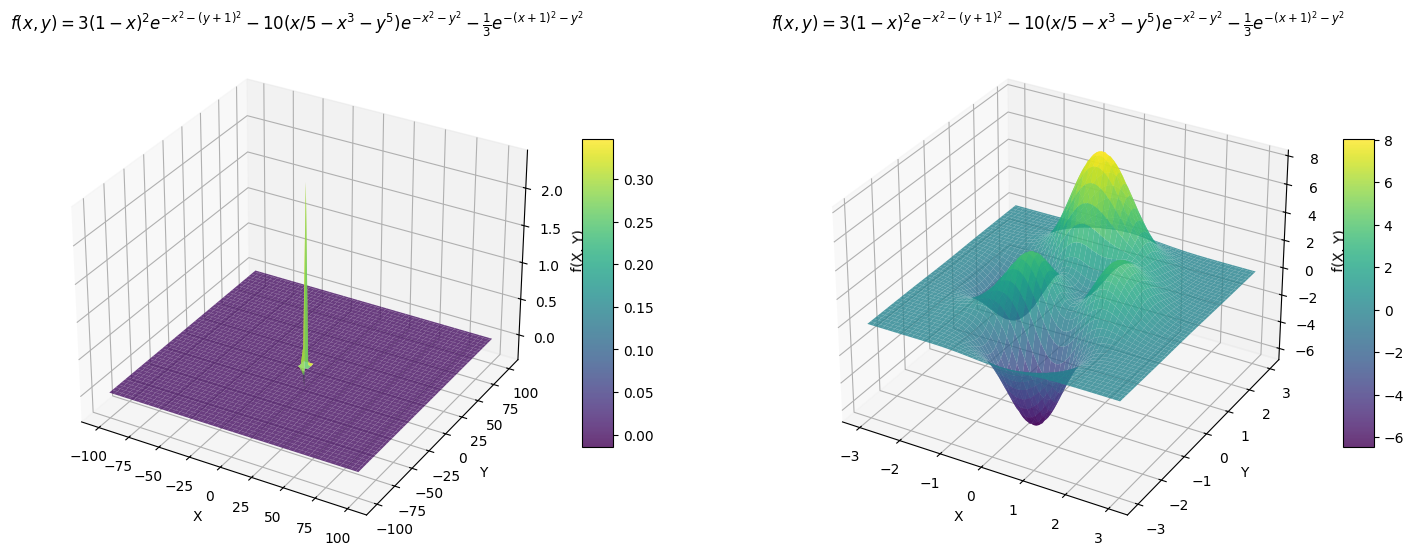

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Función
def f(x, y):
    return 3*(1-x)**2*np.exp(-x**2-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3*np.exp(-(x+1)**2-y**2)

# Rango gráfica 1
x1 = np.linspace(-100, 100, 100)
y1 = np.linspace(-100, 100, 100)

X1, Y1 = np.meshgrid(x1, y1)
Z1 = f(X1, Y1)

#Rango gráfica 2
x2 = np.linspace(-3, 3, 100)
y2 = np.linspace(-3, 3, 100)

X2, Y2 = np.meshgrid(x2, y2)
Z2 = f(X2, Y2)

fig = plt.figure(figsize=(18, 8))

# Gráfica 1
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X1, Y1, Z1, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('f(X, Y)')
title_text1 = r'$f(x, y) = 3(1-x)^2e^{-x^2-(y+1)^2} - 10(x/5 - x^3 - y^5)e^{-x^2-y^2} - \frac{1}{3}e^{-(x+1)^2-y^2}$'
ax1.set_title(title_text1, fontsize=12)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

#Gráfica 2
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X2, Y2, f(X2, Y2), cmap='viridis', edgecolor='none', alpha=0.8)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('f(X, Y)')
title_text2 = r'$f(x, y) = 3(1-x)^2e^{-x^2-(y+1)^2} - 10(x/5 - x^3 - y^5)e^{-x^2-y^2} - \frac{1}{3}e^{-(x+1)^2-y^2}$'
ax2.set_title(title_text2, fontsize=12)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.show()

Observamos que la función alcanza un máximo absoluto en para lo valores centrales de x e y. Por ello, vamos hemos restringido los límites de la gráfica y tomaremos un sub dominio, que usaremos para producir individuos aleatorios, que inicien en valores centrales de x e y. De esta manera, ahorramos en iteraciones, inicializando la población para valores próximos al máximo.

Además vemos en la segunda gráfica, que hay 1 mínimo absoluto y 3 máximos, es decir, 2 de ellos son máximos relativos y el restante es absoluto (al que queremos llegar).

In [6]:
VALID_RANGE_INITIAL = (-3, 3)

Elegimos un tamaño de población de 32 para obtener un procedimiento similar a ejemplos anteriores además cumple con el requisito de que es **divisibles entre 4**

In [7]:
POPULATION_SIZE = 32

toolbox = base.Toolbox()

En el Toolbox registraremos funciones necesarias para ejecutar el AG, a través del método `register` de la clase base.Toolbox que tiene los atributos:

- `alias`: El nombre con el que registramos la función en el Toolbox
- `function`: La función que estamos registrando
- `argument`: Los argumentos que se pasan a la función

Registramos la función `attr_uniform` (Que será un método de la clase `toolbox`) que permite **crear individuos aleatorios** desarrollando una función (usaremos `random.uniform`) que nos permita generar un valor aleatorio para cada variable independiente (cada gen del comosoma), esto es, cada una de las posiciones de la lista con valores sujetos a las restricciones de nuestro problema (-100, 100)

In [8]:
# Generación de genes
toolbox.register("attr_uniform", random.uniform, *VALID_RANGE_INITIAL)

In [9]:
# Probamos y vemos que generamos un número leatorio entre -3 y 3 distinto cada vez
toolbox.attr_uniform()

0.8365607907473027

Creamos el individuo completo llamando a la función que genera cada uno de los individuos tantas veces como variables independientes tengamos. Eso lo hacemos registrando la función individual que, a su vez, llama a la función tools.initRepeat que tiene los siguientes parámetros:

- `container`: Tipo de dato donde se almacenará el resultado del argumento func -> En nuestro caso, la clase creator.individual creada anteriormente
- `func`: Función a la que se llamará n veces -> En nuestro caso toolbox.
- `attr_uniform` creada anteriormente para crear cada gen
- `n`: Número de veces que se llamará a la función func-> En nuestro caso 2 cromosomas a crear

In [10]:
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_uniform, INDIVIDUAL_SIZE)

In [11]:
# Ejemplo de la generación de un individuo aleatorio
individuo = toolbox.individual()
individuo

[-2.8499354686639986, -1.3498240897852845]

Ahora, registramos la función de fitness:

In [12]:
toolbox.register("evaluate", partial(evaluate_fit, target_function=F, gene_range=VALID_RANGE))
# Ejemplo de uso 1
F(individuo[0], individuo[1])

-0.0030682496832484837

La función fitness devuelve una tupla ya que la solución es generalista para un problema genérico multiobjetivo, aunque en nuestro caso solo sea uno.

In [13]:
# Recordar que individuo es una lista que tiene un atributo fitness
# donde se almacena la calidad del mismo, que al principio será
# vacío, porque aun no ha sido evaluado
individuo.fitness.values

()

El procedimiento para crear una población es análogo a la creación de un individuo:

In [14]:
# Generación de población
toolbox.register("population", tools.initRepeat, list, toolbox.individual, POPULATION_SIZE)

Como se puede ver, se registra la función `population` que utiliza `initRepeat` para llamar 32 veces a la función `Individual` (una vez por cad individuo que formará la población inicial). El resultado se guarda en una `list` que contiene la población inicial generada. Se recomienda elegir números **divisibles entre 4**, ya que algunas operaciones genéticas del módulo `deap` pueden dar problemas si no se cumple este requisito

In [15]:
# Ejemplo de creación de una población. Se ve que es
# una lista de 32 listas (una por cada individuo)
poblacion = toolbox.population()
print(poblacion)

[[-1.6607355711070635, 1.418827284984074], [1.0601969245374683, 2.3530774062290725], [-2.478367004223503, -0.46846908188837766], [-2.8212166833715777, -1.6881721511783798], [0.03213172862017455, -2.8407841818968183], [-1.806974095880109, 0.8993066266771392], [0.26964888361930006, -1.6773562677558198], [0.5355941032554523, 1.8565827400669601], [-2.961007441931634, 1.8349155109968471], [1.1888363699293611, -0.9584969008920488], [-2.0671230011293105, 2.743278433240687], [-0.9804327293242396, -2.4435249397191123], [-2.419701738999216, 2.084966198084759], [0.6223561882013464, 1.8427696396462814], [1.3783907201629075, 0.21736854872820466], [2.838694583876224, -0.7287937367498794], [0.3122437876393622, 1.9764279855179687], [0.7111185141854763, 2.170241401864663], [0.46411287154057224, 1.2274310172895406], [-2.7250536980660267, -1.6326103460907189], [-1.263672218387357, -2.521248138458235], [-1.603254681833819, -2.3939914235416255], [-1.3321583813394473, 0.8141066655864009], [-0.81100692617949

In [16]:
poblacion[0].fitness.values

()

La función fitness devuelve una tupla ya que la solución es generalista para un problema genérico multiobjetivo, aunque en nuestro caso solo sea uno.

## Incorporar los operadores genéticos

Preparamos los valores iniciales y constantes que usaremos para el algoritmo.

* **Selección**:`selection`. Procedimiento por el cual se seleccionan los individuos que participarán en las operaciones de cruce y mutación. Procedimiento siempre **elitista**: Un individuo tendrá mayor probabilidad de dejar descendencia si su `fitness` es más adecuado al problema de optimización (razonamiento en línea con la teoría evolutiva de Darwin) -> Las probabilidades de dejar descendencia en las futuras generaciones crecen cuando crece la adaptación del individuo al medio. **OJO CON LOS SUPERINDIVIDUOS**
* **Cruce**: `mate`. Operación probabilística que permite que dos individuos seleccionados **crucen** o **intercambien** su información genética para crear dos nuevos individuos
* **Mutación**: `mutation`. Operación probabilística que permite que un individuo seleccionado **modifique** su información genética para crear un nuevo individuo.

Ni para la probabilidad de cruce ni para la de mutación existen valores óptimos que sirva para todos los problemas. Tendrán que ajustarse a cada problema.

Destacar que tanto el **cruce** como la **mutación** son el **motor para explorar y explotar zonas del espacio de búsqueda**.

In [17]:
MU = 0 # mean
SIGMA = 5 # standard deviation
INDPB = 0.1 # independent probability for each atribute to be mutated
TOURNAMENT_SIZE = 3

## Cruce

Utilizamos ``cxOnePoint(ind1, ind2)`` o cruce en un punto que ya conocéis `cxOnePoint`, selecciona de manera aleatoria un punto (una posición) dentro de los individuos `ind1`, `ind2` para hacer un intercambio entre la información genética de dos individuos (padres) seleccionados


In [18]:
# CRUCE
toolbox.register("mate", tools.cxOnePoint)

En este caso, al ser la longitud de los individuos 2, solo existe un posible punto de cruce (el cruce será simplemente intercambiar los valores de x e y)

## Mutación

Utilizamos el operador `mutGaussian` (mutación Gaussiana) con una media de 0 y una deviación típica de 5 (son solo de ejemplo y no garantizan ser los más adecuados. Posiblemente habrá que probar valores distintos)

In [19]:
# MUTACIÓN
toolbox.register("mutate", tools.mutGaussian, mu=MU, sigma=SIGMA, indpb=INDPB)

`MutGaussian` consiste en mutar, con una probabilidad `indpb` cada uno de los genes del individuo `individual`, sumando a cada uno de ellos una cierta cantidad aleatoria. Esta cantidad se genera según una función de probabilidad Gaussiana (o normal), de media `mu` y desviación típica `sigma`.

En el caso de la mutación, se deben definir dos probabilidades:

- La probabilidad de mutar un individuo (lo veremos más adelante)
- La probabilidad de mutar cada uno de los genes del individuo (`indpb`)

Este último valor, en general, debe ser bajo para que la mutación no modifique en exceso al individuo. Valores muy altos de esta probabilidad pueden hacer que el algoritmo no converja correctamente, o que no se intensifiquen ciertas zonas del espacio de búsqueda.

## Selección

In [20]:
# SELECCIÓN
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

Hemos usado el operador `selTournament(individuals, k, tournsize)` que nos permite realizar una selección mediante torneo. En este caso fijamos un tamaño igual a 3. Se ha demostrado que este tamaño funciona relativamente bien para la mayoría de los casos Lones 2011

El algoritmo realiza tantos torneos como individuos tiene la población. Aunque 3 es válido para la mayoría de los casos, cuando la población crece mucho, se deben utilizar tamaños más altos para hacer más rápida la convergencia del algoritmo. La selección con torneo es muy elitista y hace que el algoritmo converja más rapidamente que, por ejemplo, con el algoritmo de la ruleta.

# Configuración del algoritmo genético

In [21]:
from deap import algorithms
import numpy as np

CXPB = 0.5  # probability of mating 2 individuals
MUTPB = 0.2 # probabilty of mutating an individual
NGEN = 20   # number of generations

#Generamos la Población Inicial
pop = toolbox.population()
print(type(pop))

# Definimos el objeto hof que almacenará el mejor individuo
# encontrado a lo largo de las generaciones del Algoritmo G.
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Ahora registramos en el objeto stats las funciones estadísticas a utilizar junto con su alias:
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

<class 'list'>


El objeto `stats` tiene un método `compile` **Método Compile**, que recibe como entrada la población que permite generar las estadísticas. A este método se le llama internamente en cada generación del algoritmo.

**ESTAMOS EN DISPOSICIÓN DE PODER EJECUTAR EL ALGORITMO GENÉTICO** ---------------------------------------------

En `deap` tenemos una ámplia gama de algoritmos en el submódulo `algorithms` [Submódulo Algorithms](https://deap.readthedocs.io/en/master/api/algo.html), en nuestro caso, usaremos `eaSimple` que es una de las versiones más simples y que realizará lo siguiente:

1. Evaluará la población inicial
2. Mientras no se alcance el límite de generaciones:
    1. Selección de individuos para participar en las operaciones genéticas
    2. Creación de la siguiente generación mediante cruce y/o mutación de los individuos seleccionados
    3. Evaluación de la generación creada

Además, el algoritmo `eaSimple`, devolverá la **población final** y el **registro de evolución** y tendrá como **parámetros de entrada**:
* `population` : Población inicial
* `toolbox` : La caja de herramientas con todas las funciones necesarias
* `cxpb` : Probabilidad de cruce en tanto por uno
* `mutpb` : Probabilidad de mutación en tanto por uno
* `ngen` : Nº de generaciones del algoritmo
* `stats` : Objeto estadístico con las funciones registradas (opcional)
* `halloffame` : Objeto del tipo HallOfFame con los mejores individuos por generación, opcional
* `verbose` : Si se deben mostrar o no las estadísticas de cada generación

In [22]:
logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg      	std    	min     	max    
0  	32    	-0.022886	2.28267	-5.78735	7.52581
1  	15    	1.96212  	2.46999	-4.17425	7.52581
2  	18    	3.73903  	2.58809	0.320446	7.721  
3  	19    	6.21131  	2.06854	-1.75478	7.721  
4  	13    	7.09283  	1.47392	1.38843e-13	7.721  
5  	24    	7.51149  	0.649678	3.99139    	7.721  
6  	23    	7.45226  	1.24501 	0.64154    	7.721  
7  	20    	6.99715  	2.25052 	-2.86862e-19	7.721  
8  	19    	7.32278  	2.21719 	-5.02202    	7.721  
9  	12    	7.721    	0       	7.721       	7.721  
10 	17    	7.721    	0       	7.721       	7.721  
11 	23    	7.47972  	1.3434  	1.9617e-06  	7.721  
12 	18    	7.721    	0       	7.721       	7.721  
13 	22    	6.99735  	2.24991 	-1.34917e-11	7.721  
14 	20    	7.43976  	1.3546  	6.26148e-20 	7.721  
15 	22    	7.42505  	1.64776 	-1.74929    	7.721  
16 	17    	7.25783  	1.79551 	-2.45966e-08	7.721  
17 	18    	7.47972  	1.3434  	3.44096e-22 	7.721  
18 	26    	7.53225  	1.05091 	1.68101     	7.721  
19 	16   

In [23]:
print(pop)

[[0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [5.197369918778458, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.17468607059482189, 1.6717588717833491], [0.174686070

In [24]:
print(logbook)

gen	nevals	avg      	std     	min         	max    
0  	32    	-0.022886	2.28267 	-5.78735    	7.52581
1  	15    	1.96212  	2.46999 	-4.17425    	7.52581
2  	18    	3.73903  	2.58809 	0.320446    	7.721  
3  	19    	6.21131  	2.06854 	-1.75478    	7.721  
4  	13    	7.09283  	1.47392 	1.38843e-13 	7.721  
5  	24    	7.51149  	0.649678	3.99139     	7.721  
6  	23    	7.45226  	1.24501 	0.64154     	7.721  
7  	20    	6.99715  	2.25052 	-2.86862e-19	7.721  
8  	19    	7.32278  	2.21719 	-5.02202    	7.721  
9  	12    	7.721    	0       	7.721       	7.721  
10 	17    	7.721    	0       	7.721       	7.721  
11 	23    	7.47972  	1.3434  	1.9617e-06  	7.721  
12 	18    	7.721    	0       	7.721       	7.721  
13 	22    	6.99735  	2.24991 	-1.34917e-11	7.721  
14 	20    	7.43976  	1.3546  	6.26148e-20 	7.721  
15 	22    	7.42505  	1.64776 	-1.74929    	7.721  
16 	17    	7.25783  	1.79551 	-2.45966e-08	7.721  
17 	18    	7.47972  	1.3434  	3.44096e-22 	7.721  
18 	26    	7.53225  	1.05091 	1

# Resultados del Algoritmo

In [25]:
print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])

Mejor fitness: 7.720998
Mejor individuo [0.17468607059482189, 1.6717588717833491]


Nos da unos valores acordes a la gráfica que hicimos anteriormente, sin embargo, para asegurarnos que no hayamos caído en un máximo local, podemos hacer algunas modificaciones al modelo, que también nos podrían ayudar a conseguir mejores resultados en menos iteraciones.

In [26]:
print(logbook)

gen	nevals	avg      	std     	min         	max    
0  	32    	-0.022886	2.28267 	-5.78735    	7.52581
1  	15    	1.96212  	2.46999 	-4.17425    	7.52581
2  	18    	3.73903  	2.58809 	0.320446    	7.721  
3  	19    	6.21131  	2.06854 	-1.75478    	7.721  
4  	13    	7.09283  	1.47392 	1.38843e-13 	7.721  
5  	24    	7.51149  	0.649678	3.99139     	7.721  
6  	23    	7.45226  	1.24501 	0.64154     	7.721  
7  	20    	6.99715  	2.25052 	-2.86862e-19	7.721  
8  	19    	7.32278  	2.21719 	-5.02202    	7.721  
9  	12    	7.721    	0       	7.721       	7.721  
10 	17    	7.721    	0       	7.721       	7.721  
11 	23    	7.47972  	1.3434  	1.9617e-06  	7.721  
12 	18    	7.721    	0       	7.721       	7.721  
13 	22    	6.99735  	2.24991 	-1.34917e-11	7.721  
14 	20    	7.43976  	1.3546  	6.26148e-20 	7.721  
15 	22    	7.42505  	1.64776 	-1.74929    	7.721  
16 	17    	7.25783  	1.79551 	-2.45966e-08	7.721  
17 	18    	7.47972  	1.3434  	3.44096e-22 	7.721  
18 	26    	7.53225  	1.05091 	1

# Convergencia del algoritmo

A partir del objeto `Logbook` [Objeto Logbook](https://deap.readthedocs.io/en/master/api/tools.html#logbook) que contiene todos los datos de evolución del algoritmo, desarrollamos la función `plot_evolution` para analizar la convergencia representando la evolución del Algoritmo Genético:

In [27]:
def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    # ax1.fill_between(gen, fit_mins, fit_maxs, where=fit_maxs >= fit_mins, facecolor='g', alpha = 0.2)
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    #ax1.set_ylim([-10, 20])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.savefig("Convergencia.eps", dpi = 300)

Pintamos la Gráfica:

Mejor fitness: 7.720998
Mejor individuo [0.17468607059482189, 1.6717588717833491]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


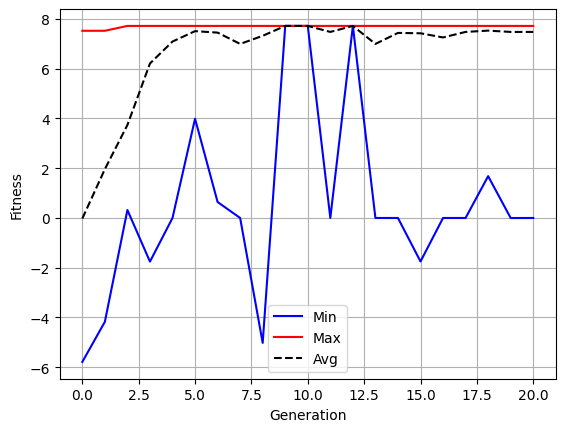

In [28]:
# Generación de población
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual, 8)
print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])
plot_evolucion(logbook)

### Probamos cambiando el cruce a por dos puntos

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


gen	nevals	avg    	std    	min     	max   
0  	8     	0.39026	2.89969	-6.42578	4.2967
1  	6     	2.87666	2.29386	0.201508	6.93523
2  	6     	2.9093 	1.79088	8.03841e-35	4.2967 
3  	3     	4.27811	0.0185985	4.25951    	4.2967 
4  	8     	4.28276	0.018008 	4.25951    	4.2967 
5  	6     	3.75962	1.421    	-3.07484e-18	4.2967 
6  	6     	3.76037	1.41901  	0.00602111  	4.2967 
7  	4     	3.75962	1.421    	8.57957e-08 	4.2967 
8  	6     	3.73395	1.48892  	-0.205366   	4.2967 
9  	5     	4.60027	0.803162 	4.2967      	6.72524
10 	3     	5.2074 	1.17571  	4.2967      	6.72524
11 	8     	4.97388	2.19044  	5.02444e-32 	6.72524
12 	3     	6.42167	0.803162 	4.2967      	6.72524
13 	7     	6.72524	0        	6.72524     	6.72524
14 	4     	6.72524	0        	6.72524     	6.72524
15 	1     	6.72524	0        	6.72524     	6.72524
16 	5     	6.72524	0        	6.72524     	6.72524
17 	6     	6.72524	0        	6.72524     	6.72524
18 	6     	5.88493	2.22325  	0.0027759   	6.72524
19 	4     	5.88517	2.2226

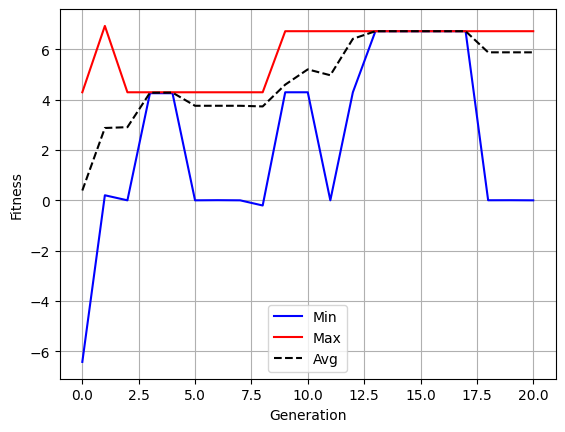

In [31]:
# Cruce por 2 puntos
toolbox.register("mate", tools.cxTwoPoint)

# Generamos una nueva población
pop = toolbox.population()

# Definimos el mejor individuo
hof = tools.HallOfFame(1)

logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])
plot_evolucion(logbook)

Como podemos observar el fitness del mejor individuo para este tipo crece es peor para estos hiperparámetros

# Posibles mejoras

Buenas prácticas a llevar a cabo para mejorar el modelo:
* Aumentar la población hasta que no veamos mejoras significativas probando con pocas generaciones e ir aumentando el número de individuos
* Aumentar el número de generaciones y comprobar que el algoritmo converja mostrando una gráfica de convergencia del algoritmo
* Hacer un barrido de valores de probabilidades de cruce y mutación, y mostrar algunas estadísticas para ver de qué manera afectan dichas probabilidades

Ahora lanzamos el Algoritmo Genético 20 veces

In [30]:
# Inicializamos la lista de las soluciones. Almacenaremos el fitness
# del mejor individuo de cada intento del algoritmo genético
lista_mejores = list()

# Lanzamos el algoritmo 20 veces

best, log = main()
lista_mejores.append(best[0].fitness.values)

# Mostramos los resultados. Al terminar el bucle, calculamos
# la mediay el mejor resultado de todos los intentos
media = np.mean(lista_mejores)
mejor_total = max(lista_mejores)
print("media: %f" %media)
print("mejor: %f" %mejor_total)

NameError: name 'main' is not defined

# Convergencia del algoritmo

A partir del objeto `Logbook` [Objeto Logbook](https://deap.readthedocs.io/en/master/api/tools.html#logbook) que contiene todos los datos de evolución del algoritmo, desarrollamos la función `plot_evolution` para analizar la convergencia representando la evolución del Algoritmo Genético:

Pintamos la Gráfica:

gen	nevals	avg    	std    	min     	max    
0  	8     	0.15092	1.30519	-2.36039	2.26763
1  	2     	1.02461	0.991635	-0.313149	2.26763
2  	4     	1.79492	0.660461	0.19238  	2.26763
3  	4     	2.24841	0.0508526	2.11387  	2.26763
4  	4     	2.26763	0        	2.26763  	2.26763
5  	4     	2.26763	0        	2.26763  	2.26763
6  	6     	1.98418	0.749948 	-3.68438e-25	2.26763
7  	4     	1.98418	0.749948 	1.49703e-31 	2.26763
8  	3     	2.26763	0        	2.26763     	2.26763
9  	3     	2.26763	0        	2.26763     	2.26763
10 	3     	2.26763	0        	2.26763     	2.26763
11 	6     	2.26763	0        	2.26763     	2.26763
12 	6     	2.26763	0        	2.26763     	2.26763
13 	5     	2.26763	0        	2.26763     	2.26763
14 	6     	1.98418	0.749948 	-4.49125e-17	2.26763
15 	6     	1.98418	0.749948 	8.92938e-08 	2.26763
16 	4     	2.44841	0.478291 	2.26763     	3.71385
17 	2     	2.80996	0.700146 	2.26763     	3.71385
18 	6     	2.99074	0.723107 	2.26763     	3.71385
19 	4     	3.71385	0        	

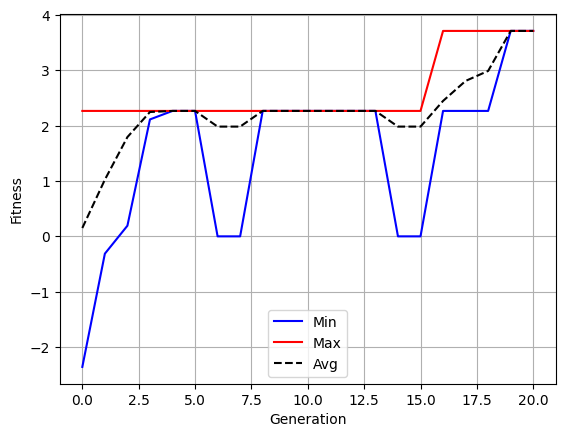

In [ ]:
# Generación de población
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual, 8)
random.seed(42)
best, log = main()
print("Mejor fitness: %f" %best[0].fitness.values)
print("Mejor individuo %s" %best[0])
plot_evolucion(log)

Se podrían evitar muchas iteraciones.

Dilema de la **exploración** vs la **explotación**: ¿Qué mecanismo u operadores genéticos favorecen la exploración cuales la explotación?. La respuesta a esta cuestión no está clara y es un **tema en discusión** en la literatura especializada. **La mezcla de selección, cruce y mutación generan exploración y explotación**

# EJERCICIO 2
Dada la [Función de Rastringin](https://en.wikipedia.org/wiki/Rastrigin_function#:~:text=In%20mathematical%20optimization%2C%20the%20Rastrigin,has%20been%20generalized%20by%20Rudolph.), con A = 10 y  $$\{xi\} \in [-5.12,5.12]$$

Implementa dicha función en Python y minimízala para n=10

Compara el funcionamiento del Algoritmo Genético para cruce con un punto con cruce con dos puntos

Definimos la función objetivo del enunciado:
$$f(\mathbf{x}) = 10 \cdot n + \sum_{i=1}^{n} \left[ x_i^2 - 10 \cdot \cos(2 \pi x_i) \right]$$

In [ ]:
import numpy as np

F = lambda x, n, A: A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))
F = partial(F, n=10, A=10)

def evaluate_fit(individual, target_function, gene_range):
    for gene in individual:
        if not (gene_range[0] <= gene <= gene_range[1]):
            return abs(target_function(np.array([*individual]))) * 1.5,
    return target_function(np.array([*individual])),

In [ ]:
# INICIALIZACIÓN DE HIPERPARÁMETROS
import random
from deap import base, creator, tools

# FitnessMin para minimizar
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

random.seed(42)           # Para obtener los mismos resultados siempre

VALID_RANGE = (-5.12, 5.12) # Dominio
n = 10
INDIVIDUAL_SIZE = n         # Hay n = 10 variables xi con i = 0,1, ...,n

# TAMAÑO DE LA POBLACIÓN
POPULATION_SIZE = 32

toolbox = base.Toolbox()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Como el número de dimensiones es `n = 10`, tenemos 10 variables $\{xi\}$ con $\{i = 1,2,3,4,5,6,7,8,9,10\}$ cada una de ellas pertenece al dominio $ [-5.12,5.12]$.

In [ ]:
# Generación de genes
toolbox.register("attr_uniform", random.uniform, *VALID_RANGE)
# Generación de individuos
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_uniform, INDIVIDUAL_SIZE)
# Registramos la función de fitness
toolbox.register("evaluate", partial(evaluate_fit, target_function=F, gene_range=VALID_RANGE))
# Generación de población
toolbox.register("population", tools.initRepeat, list, toolbox.individual, POPULATION_SIZE)


## Incorporar los operadores genéticos

Preparamos los valores iniciales y constantes que usaremos para el algoritmo.
Definiremos la probabilidad de cruce, mutación y método de selección.

In [ ]:
MU = 0            # mean
SIGMA = 5         # standard deviation
INDPB = 0.1       # independent probability for each atribute to be mutated
TOURNAMENT_SIZE = 5

In [ ]:
# CRUCE
toolbox.register("mate", tools.cxOnePoint)
# MUTACIÓN
toolbox.register("mutate", tools.mutGaussian, mu=MU, sigma=SIGMA, indpb=INDPB)
# SELECCIÓN
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Configuración del algoritmo genético

In [ ]:
from deap import algorithms
import numpy as np

CXPB = 0.5  # probability of mating 2 individuals
MUTPB = 0.2 # probabilty of mutating an individual
NGEN = 80  # number of generations

#Generamos la Población Inicial
pop = toolbox.population()
print(type(pop))

# Definimos el objeto hof que almacenará el mejor individuo
# encontrado a lo largo de las generaciones del Algoritmo G.
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Ahora registramos en el objeto stats las funciones estadísticas a utilizar junto con su alias:
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

<class 'list'>


In [ ]:
logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	32    	190.911	29.4728	121.772	250.492
1  	13    	191.293	198.228	121.772	1282.76
2  	20    	146.28 	65.4793	101.152	427.294
3  	19    	130.863	41.4267	101.152	309.694
4  	24    	118.635	29.8428	95.5626	270.089
5  	21    	102.4  	7.11164	86.4053	121.772
6  	19    	102.345	31.5911	86.4053	273.16 
7  	14    	92.9521	18.6858	82.9369	194.357
8  	19    	95.3137	33.4372	80.8154	244.909
9  	22    	95.1882	40.4112	68.2426	275.618
10 	21    	90.3489	35.8521	68.2426	227.294
11 	19    	79.104 	20.7025	67.0395	190.264
12 	18    	75.906 	25.0857	56.2686	170.83 
13 	17    	96.721 	85.648 	55.0655	377.049
14 	20    	61.868 	8.09131	55.0655	85.1553
15 	22    	79.7204	72.4148	55.0655	365.072
16 	18    	75.994 	51.2142	55.0655	247.06 
17 	14    	59.5599	21.5701	47.3808	175.534
18 	19    	73.9103	65.4903	47.3808	336.003
19 	20    	89.7794	94.3964	47.3808	488.746
20 	16    	66.9348	45.6611	47.3808	244.521
21 	14    	54.9301	19.0643	47.3808	124.171
22 	19    	

# Resultados del Algoritmo

In [ ]:
print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])

Mejor fitness: 36.819695
Mejor individuo [-0.8271368669606662, 0.07958693837350284, -0.9954663861073227, -0.06896458914192438, 0.017594683875336692, -3.0473881672342036, 1.76977478367861, 0.9753034650848442, -0.05562891804896619, -0.8618369107327049]


In [ ]:
from deap import algorithms
import numpy as np

CXPB = 0.5 # probability of mating 2 individuals
MUTPB = 0.2 # probabilty of mutating an individual
NGEN = 20 # number of generations

pop = toolbox.population()
print(type(pop))

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	32    	190.911	29.4728	121.772	250.492
1  	13    	191.293	198.228	121.772	1282.76
2  	20    	146.28 	65.4793	101.152	427.294
3  	19    	130.863	41.4267	101.152	309.694
4  	24    	118.635	29.8428	95.5626	270.089
5  	21    	102.4  	7.11164	86.4053	121.772
6  	19    	102.345	31.5911	86.4053	273.16 
7  	14    	92.9521	18.6858	82.9369	194.357
8  	19    	95.3137	33.4372	80.8154	244.909
9  	22    	95.1882	40.4112	68.2426	275.618
10 	21    	90.3489	35.8521	68.2426	227.294
11 	19    	79.104 	20.7025	67.0395	190.264
12 	18    	75.906 	25.0857	56.2686	170.83 
13 	17    	96.721 	85.648 	55.0655	377.049
14 	20    	61.868 	8.09131	55.0655	85.1553
15 	22    	79.7204	72.4148	55.0655	365.072
16 	18    	75.994 	51.2142	55.0655	247.06 
17 	14    	59.5599	21.5701	47.3808	175.534
18 	19    	73.9103	65.4903	47.3808	336.003
19 	20    	89.7794	94.3964	47.3808	488.746
20 	16    	66.9348	45.6611	47.3808	244.521
21 	14    	54.9301	19.0643	47.3808	124.171
22 	19    	

Obtenemos el mínimo en 323.6 para 10 valores de x listados anteriormente.

# Convergencia del algoritmo

Pintamos la Gráfica:

Mejor fitness: 36.819695
Mejor individuo [-0.8271368669606662, 0.07958693837350284, -0.9954663861073227, -0.06896458914192438, 0.017594683875336692, -3.0473881672342036, 1.76977478367861, 0.9753034650848442, -0.05562891804896619, -0.8618369107327049]


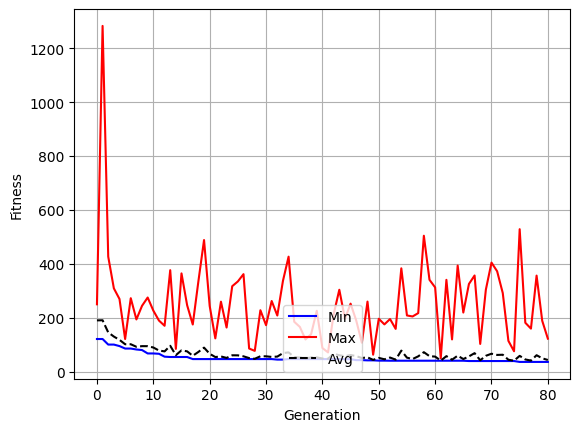

In [ ]:
# Generación de población
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual, 8)
print("Mejor fitness: %f" %hof[0].fitness.values)
print("Mejor individuo %s" %hof[0])
plot_evolucion(logbook)

### Instalación de librerías para resolver Algoritmos Genéticos con Python

In [ ]:
#!pip install deap
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
#!pip install scoop